# Word Embeddings Solution

###### Author: Alex Sherman | alsherman@deloitte.com


##### Agenda
- Vector Space Model
- PCA
- SVD
- latent semantic indexing (LSI/LSA)
- latent dirichlet allocation(LDA)
- topic coherence metrics
- Word2Vec
- T-SNE

SOURCES: 
https://github.com/makeyourowntextminingtoolkit/makeyourowntextminingtoolkit
ftp://ftp.sas.com/techsup/download/EMiner/TamingTextwiththeSVD.pdf

In [26]:
from collections import defaultdict
from configparser import ConfigParser, ExtendedInterpolation
from IPython.core.display import display, HTML
from IPython.display import Image
from IPython.lib.display import YouTubeVideo
import pandas as pd
import spacy
from spacy.matcher import Matcher, PhraseMatcher
from spacy.lang.en.stop_words import STOP_WORDS
from gensim import corpora, models

config = ConfigParser(interpolation=ExtendedInterpolation())
config.read('../../config.ini')
GENSIM_DICTIONARY_PATH = config['NLP']['GENSIM_DICTIONARY_PATH']
GENSIM_CORPUS_PATH = config['NLP']['GENSIM_CORPUS_PATH']
AIRLINE_ACRONYMS_FILEPATH = config['NLP']['AIRLINE_ACRONYMS_FILEPATH']
AIRLINE_CLEANED_TEXT_PATH = config['NLP']['AIRLINE_CLEANED_TEXT_PATH']
AIRLINE_LSI_MODEL_PATH = config['NLP']['AIRLINE_LSI_MODEL_PATH']
AIRLINE_LDA_MODEL_PATH = config['NLP']['AIRLINE_LDA_MODEL_PATH']

### Word embedding
"Word embedding is the collective name for a set of language modeling and feature learning techniques in natural language processing (NLP) where words or phrases from the vocabulary are mapped to vectors of real numbers. Conceptually it involves a mathematical embedding from a space with one dimension per word to a continuous vector space with much higher dimension.

Methods to generate this mapping include neural networks, dimensionality reduction on the word co-occurrence matrix, probabilistic models, and explicit representation in terms of the context in which words appear.

Word and phrase embeddings, when used as the underlying input representation, have been shown to boost the performance in NLP tasks such as syntactic parsing and sentiment analysis."

##### There are many techniques to create Word Embeddings. Some of the popular ones are:

- Binary Encoding
- TF Encoding
- TF-IDF Encoding
- Latent Semantic Analysis Encoding
- Topic Modeling
- Word2Vec Encoding

SOURCE: https://en.wikipedia.org/wiki/Word_embedding

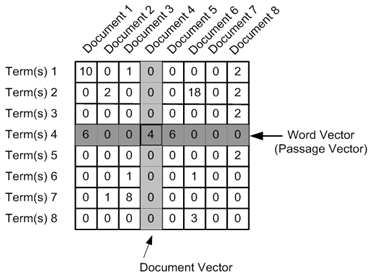

In [30]:
# Document and Word Vectors
Image("../../raw_data/images/word_vector.png", width=400, height=400)

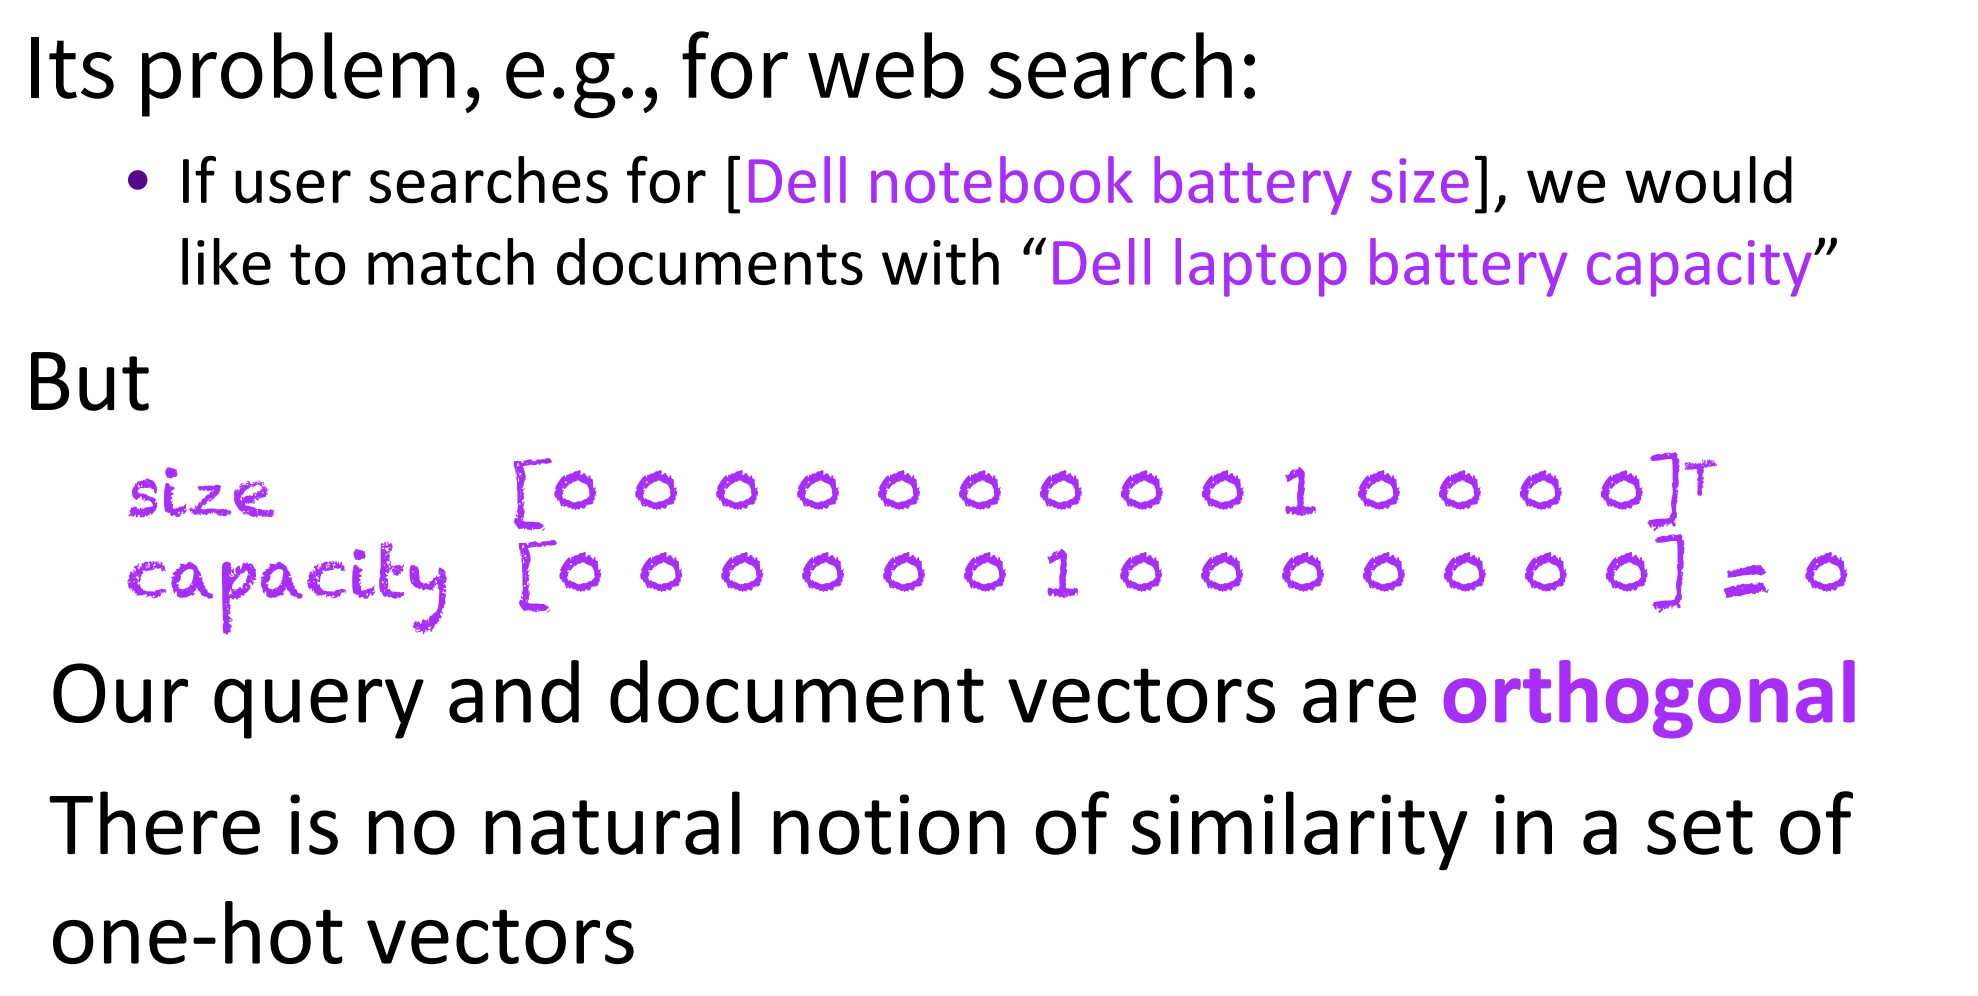

In [28]:
# problems with symbolic word representations
Image("../../raw_data/images/symbolic_word_representations.png", width=400, height=400)

# Text Vectorization (gensim)

In [60]:
with open(AIRLINE_CLEANED_TEXT_PATH, 'r') as f:
    texts = list(set([row.strip() for row in f]))

# convert each line of text into a list of tokens
# required later for gensim
texts = [text.split() for text in texts]
    
print(texts[0])

['the', 'white', 'house', 'have', 'propose', 'increase', 'the', 'security', 'fee', 'assess', 'on', 'passenger', 'a', 'good', 'a', 'create', 'a', 'new', 'aircraft', 'departure', 'tax', 'of', 'per', 'flight', 'to', 'help', 'pay', 'for', 'deficit_reduction']


In [61]:
# turn our tokenized documents into a id <-> term dictionary
dictionary = corpora.Dictionary(texts)
dictionary

In [62]:
# filter the dictionary to remove infrequent (no_below) and too frequent (no_above) terminology
dictionary.filter_extremes(no_below=2, no_above=0.4)

In [63]:
# save the dictionary - we will use it again in different notebooks
dictionary.save(GENSIM_DICTIONARY_PATH)  

Here we assigned a unique integer ID to all words appearing in the processed corpus with the gensim.corpora.dictionary.Dictionary class. This sweeps across the texts, collecting word counts and relevant statistics. In the end, we see there are twelve distinct words in the processed corpus, which means each document will be represented by twelve numbers (ie., by a 12-D vector). To see the mapping between words and their ids:

In [64]:
print(dictionary.token2id)

{'take': 521, 'expense': 176, 'who': 115, 'pet_liquor': 402, 'miles_rewards': 401, 'available_seat_mile': 54, 'motion': 287, 'baggage': 79, 'company_ability': 592, 'continue': 57, 'june': 204, 'asif_on_each_airline': 281, 'total': 188, 'numb_of_total': 358, 'affect': 584, 'land_fee': 435, 'board_position': 253, 'premium': 636, 'customers_on_behalf': 527, 'book': 81, 'severance': 298, 'flight': 4, 'refund_passenger': 530, 'weight': 391, 'conjurer': 124, 'cbp': 652, 'income': 303, 'approximately_percent': 482, 'white': 18, 'from': 195, 'flight_ii': 529, 'would': 202, 'form': 449, 'company_currently': 56, 'change_in_law': 589, 'initiative': 541, 'minimum_of_per_one_way': 577, 'ii_refund': 512, 'change_to_environmental': 590, 'other': 90, 'use_to_support': 654, 'however': 428, 'pay': 13, 'purchase_of_miles': 404, 'with': 77, 'credit': 462, 'seniority': 657, 'technology': 504, 'decision': 499, 'additional_yearly': 575, 'flight_crow': 486, 'respect': 73, 'approve_legislation': 419, 'sell': 6

In [76]:
# map two docuemtns using doc to bag of words

print('Document 0: {}'.format(texts[0]))
print(dictionary.doc2bow(texts[0]))

print('\nDocument 1: {}'.format(texts[1]))
print(dictionary.doc2bow(texts[1]))

Document 0: ['the', 'white', 'house', 'have', 'propose', 'increase', 'the', 'security', 'fee', 'assess', 'on', 'passenger', 'a', 'good', 'a', 'create', 'a', 'new', 'aircraft', 'departure', 'tax', 'of', 'per', 'flight', 'to', 'help', 'pay', 'for', 'deficit_reduction']
[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1)]

Document 1: ['these', 'taxis_and_fee', 'include', 'foreign', 'and', 'federal_transportation', 'taxis_federal', 'security', 'charge', 'and', 'airport', 'passenger', 'facility_charge']
[(12, 1), (16, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1)]


In [79]:
# notice that 'passenger' appears in both documents and is mapped to the same id
dictionary[12]

# the second number in each tuple is the count
print(dictionary.doc2bow(['passenger','passenger','passenger']))

[(12, 3)]


The function doc2bow() simply counts the number of occurrences of each distinct word, converts the word to its integer word id and returns the result as a bag-of-words--a sparse vector, in the form of [(word_id, word_count), ...].

For a token_id of 0 for "human" and 2 for "computer", the new document “Human computer interaction” will be transformed to [(0, 1), (2, 1)]. The words "computer" and "human" exist in the dictionary and appear once. Thus, they become (0, 1), (2, 1) respectively in the sparse vector. The word "interaction" doesn't exist in the dictionary and, thus, will not show up in the sparse vector. The other ten dictionary words, that appear (implicitly) zero times, will not show up in the sparse vector and , ,there will never be a element in the sparse vector like (3, 0).

For people familiar with scikit learn, doc2bow() has similar behaviors as calling transform() on CountVectorizer. doc2bow() can behave like fit_transform() as well. For more details, please look at gensim API Doc.

In [80]:
# convert tokenized documents into a document-term matrix
corpus = [dictionary.doc2bow(sent) for sent in texts]

In [83]:
print(corpus[0])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1)]


In [84]:
# store to disk - we will use it again in different notebooks
corpora.MmCorpus.serialize(GENSIM_CORPUS_PATH, corpus)

### Semantic transformations
A transformation is something that takes a corpus and spits out another corpus on output, using the following syntax:
- corpus_out = transformation_object[corpus_in]

What exactly happens in between is determined by what kind of transformation we're using, options include the following:
- Latent Semantic Indexing (LSI)
- Latent Dirichlet Allocation (LDA)
- Random Projections (RP) 
- etc.

Some transformations need to be initialized (i.e. trained) before they can be used.

SOURCE: https://radimrehurek.com/topic_modeling_tutorial/2%20-%20Topic%20Modeling.html

In [94]:
# initialize a tfidf model (similary to TfidfTransformer from sklearn)
tfidf = models.TfidfModel(corpus)

print(tfidf[corpus[0]])

[(0, 0.23720442292876182), (1, 0.28296831862542604), (2, 0.2639745857982247), (3, 0.24924190204197363), (4, 0.14567663153543345), (5, 0.21043426005929902), (6, 0.13094394777918236), (7, 0.30973848149488886), (8, 0.30973848149488886), (9, 0.09213630579650775), (10, 0.2639745857982247), (11, 0.0798953647491712), (12, 0.11709749673027356), (13, 0.1646703643626348), (14, 0.11362178133262363), (15, 0.30973848149488886), (16, 0.17670784347584656), (17, 0.30973848149488886), (18, 0.30973848149488886)]


In [96]:
tfidf_transform = tfidf[corpus]
tfidf_transform

## Dimensionality Reduction

##### Limitations of the vector space model:

We generally do not want to feed a large number of features directly into a machine learning algorithm because:
- They are expensive to store.
- They slow down computations (e.g. in algorithms like k nearest neighbors)
- Large samples are required to avoid overfitting.


**Synonymy:** the characteristic of language to have several terms that mean essentially the same thing
-  In the SAS technical support data set the terms “frozen” and “hangs” often refer to the same situation where the program has reached a point where nothing is happening and yet the user cannot continue working

**Polysemy:** is the tendency for the same term to mean different things in different contexts.
- The term “monitor” in technical support data is a good example of this. At times it refers to the computer screen, sometimes it refers to a piece of software that displays a graphical result and still other times it refers to the user “watching” or “observing” an event

**Term dependence:** refers to the tendency for certain terms to be highly correlated with one another. This problem is not unique to text but also occurs with most other sets of data as well. 
- The terms “error” and “message” are strongly correlated in the technical support collection. When one occurs, the other also tends to occur. A pair of documents, each containing these two terms, may have their similarity overrated in this case

SOURCE: 
https://davidrosenberg.github.io/ml2015/docs/13.Lab.PCA-SVD-LDA.pdf
ftp://ftp.sas.com/techsup/download/EMiner/TamingTextwiththeSVD.pdf

### Principal Component Analysis (PCA)

PCA is used to decompose a multivariate dataset in a set of successive orthogonal components that explain a maximum amount of the variance

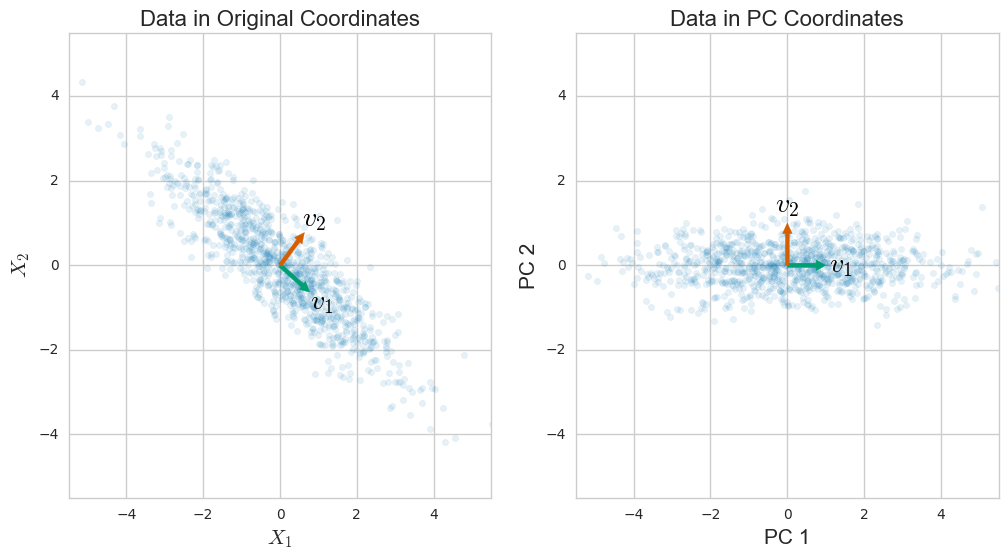

In [101]:
# PCA
# SOURCE: https://intoli.com/blog/pca-and-svd/
Image("../../raw_data/images/pca.png", width=700, height=700)

### Singular Value Decomposition

In linear algebra, the singular-value decomposition (SVD) is a factorization of a real or complex matrix.

Let A be an m × n term-document frequency matrix with rank r, r ≤ n. Without loss of generality let m ≥ n hold so that there are more terms than documents. The singular value decomposition of A can be stated succinctly as A = U*Σ*VT,

- U is an m × r orthogonal matrix whose columns make up the left singular vectors
- Σ is an r × r dimensional diagonal matrix whose diagonal elements are termed singular values
- V is an r × northogonal matrix whose columns form the right singular vectors of A.

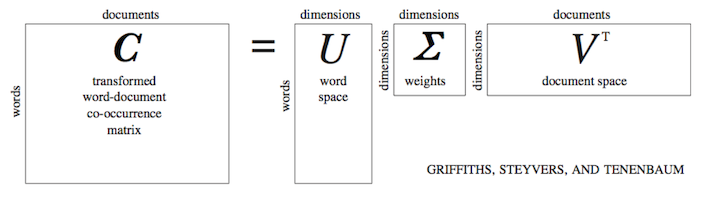

In [5]:
# SVD
Image("../../raw_data/images/svd_graph.png", width=700, height=700)

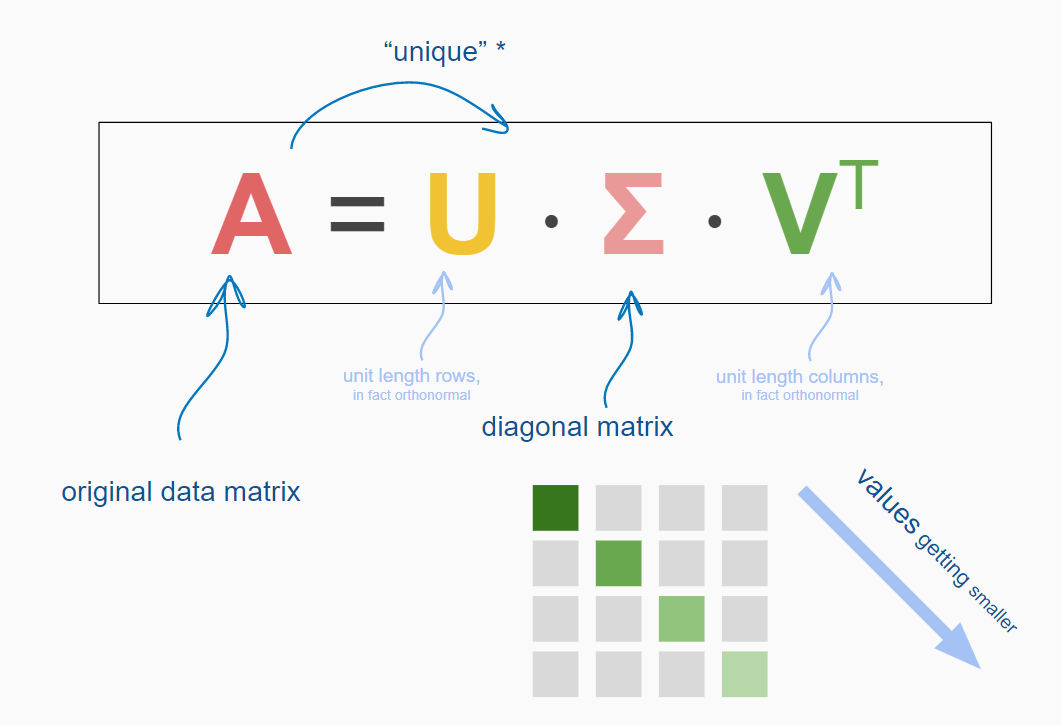

In [144]:
# SVD
Image("../../raw_data/images/svd3.png", width=400)

##### Reduced SVD

The SVD comes in two forms, a full SVD, and a reduced SVD. In NLP, we tend to focus on the reduced SVD, using SVD for dimensionality reduction.

SVD can be viewed as a sum of rank one matrices.The matrix A can then be approximated by choosing any k ≤ r. This generates a rank k matrix, Ak, that is the best rank-k approximation to A in terms of least-squares best fit

SOURCE: ftp://ftp.sas.com/techsup/download/EMiner/TamingTextwiththeSVD.pdf

"Singlular Value Decomposition (SVD) allows us to reduce the dimensionality of a matrix. Instead of analyzing a full document-term matrix with all documents and all terms, we can reduce the matrix into a lower rank representation. In this, we combine the meaning of terms by compressing the number of columns.

To reduce the size of our matrix without losing much quality, we can perform a low-rank approximation on matrix C. This is done by keeping the top k values of Σ and setting the rest to zero, where k is the new rank. Since Σ contains eigenvalues in descending order, and the effect of small eigenvalues on matrix products is small (Manning et al. 2008:411), the zeroing of the lowest values will leave the reduced matrix C' approximate to C. How to retrieve the most optimal k is not an easy task, since we want k top large enough to include as much variety as possible from our original matrix C, but small enough to exclude sampling errors and redundancy. To do this in a formal way, the Frobenius norm can be applied to measure the discrepancy between C and C_k (ibid.:410). A less extensive way is just to try out a couple of different k-values and see what generates the best results."

SOURCE: https://simonpaarlberg.com/post/latent-semantic-analyses/

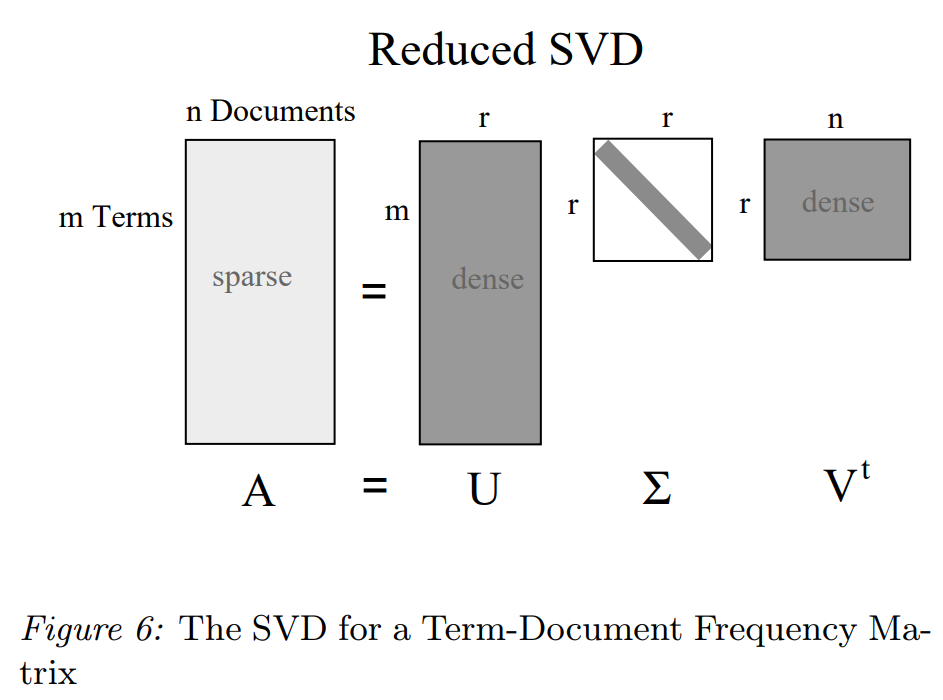

In [104]:
# reduced SVD
Image("../../raw_data/images/reduced_svd.png", width=500, height=700)

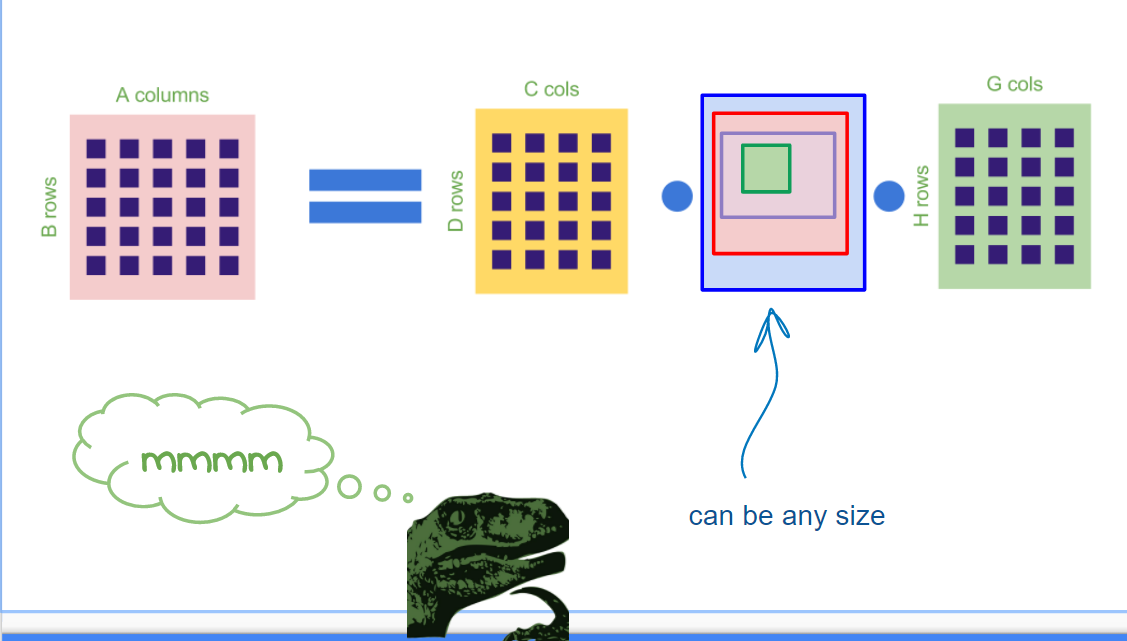

In [143]:
# SVD
Image("../../raw_data/images/svd2.png", width=700)

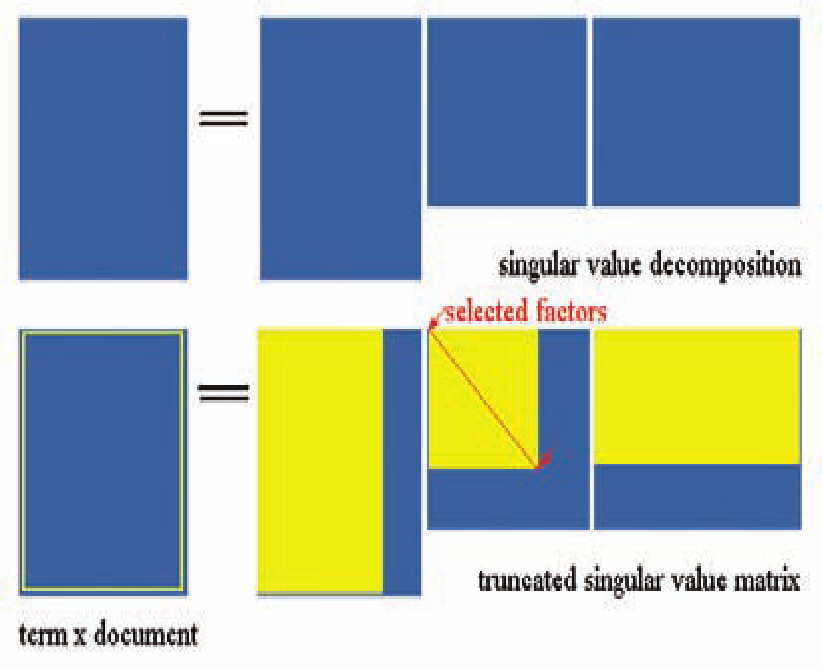

In [142]:
# Truncated SVD
# SOURCE: https://www.researchgate.net/figure/Singular-value-decomposition-SVD-and-a-truncated-SVD-matrix_fig1_227060873
Image("../../raw_data/images/truncated_svd.png", width=500)

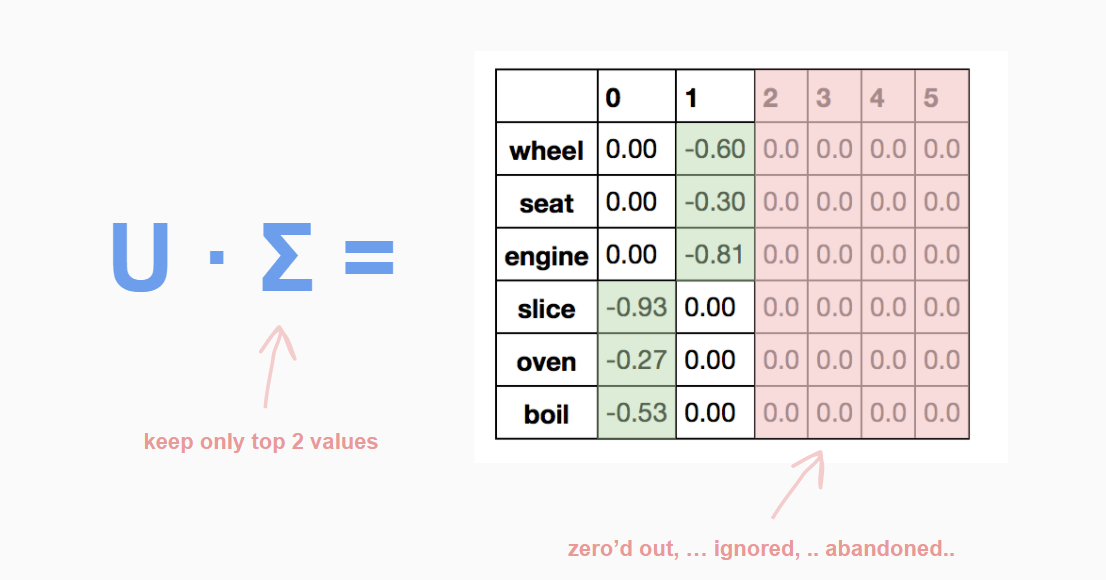

In [117]:
# SVD
Image("../../raw_data/images/svd4.png", width=700, height=700)

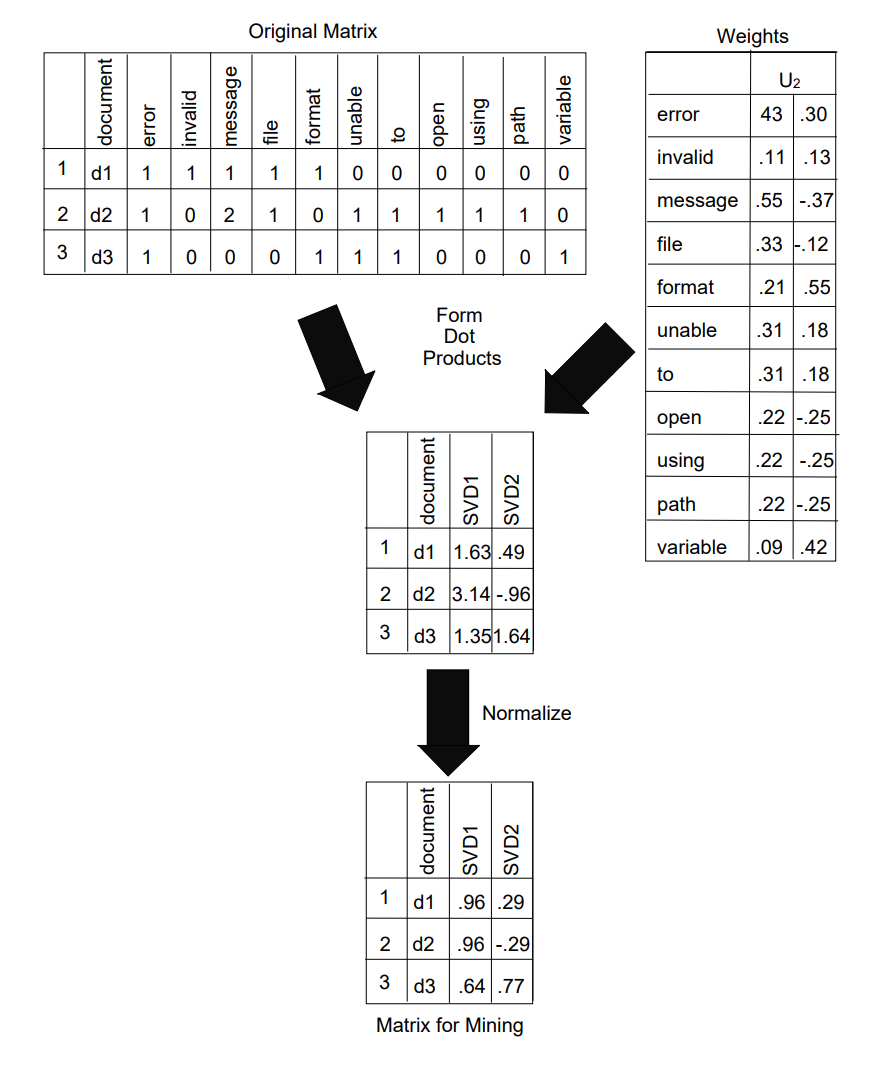

In [141]:
Image("../../raw_data/images/svd_visual_equation.png", width=600)

##### SVD approximation equation
Equation 1 implies that one can get a rough approximation to A by taking the product of the first singular value with the matrix formed from the outer product of the first column of U with the first column of V . The matrix formed, A1, will be m × n but will be of only rank one. Of all possible matrices, B, of rank one, ||A − B||2 will be smallest when B = A1 holds. One can improve the approximation by forming the product of the second singular value with the outer product of the second columns of U and V , and then adding this result to A1. The resultant matrix, A2, will be the the best rank-two approximation to A. The approximations can be successively improved by repeating the process until k = r holds and the original matrix is produced.

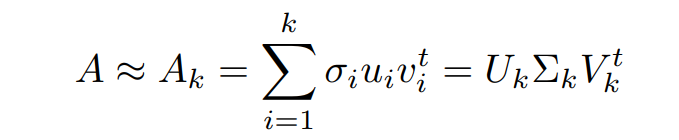

In [105]:
# reduced SVD equation
Image("../../raw_data/images/svd_truncated_equation.png", width=500, height=700)

In [23]:
svd_url = r'https://d18ky98rnyall9.cloudfront.net/T8lcsq_6EeamBAoLccicqA.processed/full/540p/index.mp4?Expires=1523404800&Signature=W02HxfadT6lOknV1FcN7uXl5ufkfXpe5skAfWkaPYDjityPKssLUFzKpy-Bs2fbIGlEOM42iJZMj0Gnge49wY8kJj1Y7ABLi-ioUrAp0G~7EduTamaVH~-lZXwHXytxBg6OQ0lGEX32S6gKWgn-UP5fRMAGZWYIhvDRzUGq7NdA_&Key-Pair-Id=APKAJLTNE6QMUY6HBC5A'
iframe = '<iframe src={} width=500 height=300></iframe>'.format(svd_url)
HTML(iframe)

# SOURCE: https://www.coursera.org/learn/matrix-factorization/lecture/K5NBy/singular-value-decomposition

### SVD Example

In [106]:
import numpy
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer

In [109]:
svd_data = [' '.join(text) for text in texts[0:10]]
vect = CountVectorizer(max_features=10, stop_words='english')
dtm = vect.fit_transform(svd_data)
vocab = vect.get_feature_names()
df = pd.DataFrame(dtm.toarray(), columns=vocab)
df

,1_quarter,airtran,available_seat_mile,bag,charge,fee,flight,passenger,rewards,security
0,0,0,0,0,0,1,1,1,0,1
1,0,0,0,0,1,0,0,1,0,1
2,0,0,0,1,1,1,1,0,0,0
3,0,0,0,0,0,1,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0
5,2,0,2,0,0,0,0,0,0,0
6,0,0,0,0,0,1,0,1,0,1
7,0,2,0,0,0,1,0,0,2,0
8,0,2,0,0,0,1,1,0,0,0
9,0,0,0,0,0,2,0,1,0,0


In [110]:
# break it down into an SVD
U, s, VT = numpy.linalg.svd(df, full_matrices=False)
S = numpy.diag(s)

In [111]:
# what are U, S and V
print("U =\n", numpy.round(U, decimals=2), "\n")
print("S =\n", numpy.round(S, decimals=2), "\n")
print("V^T =\n", numpy.round(VT, decimals=2), "\n")

U =
 [[-0.35  0.38  0.    0.06 -0.17 -0.3   0.52  0.46  0.2   0.29]
 [-0.14  0.33  0.    0.23 -0.65  0.15 -0.49 -0.21  0.06  0.29]
 [-0.28  0.19  0.   -0.74 -0.14  0.36 -0.14  0.28 -0.08 -0.29]
 [-0.17  0.08  0.   -0.04  0.35  0.08 -0.13  0.07 -0.69  0.58]
 [-0.02  0.02  0.   -0.28 -0.08  0.33  0.55 -0.64  0.09  0.29]
 [ 0.    0.   -1.    0.    0.    0.    0.    0.    0.    0.  ]
 [-0.29  0.35  0.    0.33 -0.03 -0.02  0.23 -0.26 -0.48 -0.58]
 [-0.53 -0.62  0.    0.32 -0.12  0.42  0.1   0.17  0.02  0.  ]
 [-0.47 -0.31  0.   -0.31 -0.09 -0.66 -0.16 -0.33 -0.03 -0.  ]
 [-0.41  0.31  0.    0.11  0.61  0.14 -0.26 -0.18  0.48 -0.  ]] 

S =
 [[ 4.13  0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    2.98  0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    2.83  0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    1.9   0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    1.7   0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    1.45  0. 

In [132]:
# U and V are othonormal
# These vectors are orthogonal to one another; form a basis for the reduced space

import numpy as np

# each vector is normalized (unit vector)
# multiply by itself returns 1
col1 = np.array([i[0] for i in U])
print(col1.dot(col1))

col2 = np.array([i[1] for i in U])
print(col2.dot(col2))

# and each vector is orthogonal to the other vectors
# multiply different vectors returns 0
col1.dot(col2)

0.9999999999999987
1.0


-2.220446049250313e-16

In [102]:
# rebuild A2 from U.S.V
A2 = numpy.dot(U,numpy.dot(S,VT))
print("A2 =\n", numpy.round(A2, decimals=2))

A2 =
 [[-0.  0.  1.  0.  1.  1. -0.  0.  1. -0.]
 [-0.  0.  1.  0.  1.  1. -0.  0. -0.  1.]
 [ 0.  3.  1. -0.  1.  0.  0.  1.  2.  0.]
 [-0.  0.  0.  0.  1. -0. -0.  0. -0.  1.]
 [ 0. -0.  0.  3.  1.  0.  0. -0.  0.  0.]
 [ 0. -0.  0.  0. -0.  0.  1.  0.  0.  0.]
 [ 2. -0.  0. -0.  0.  0.  1. -0.  1.  0.]
 [-0.  0. -0.  0.  1. -0. -0.  1. -0. -0.]
 [ 0. -0.  0. -0. -0.  0.  1.  0.  0.  0.]
 [-0.  0. -0.  0.  1. -0. -0.  0. -0.  1.]]


In [108]:
# S_reduced is the same as S but with only the top 3 elements kept
S_reduced = numpy.zeros_like(S)
# only keep top two eigenvalues
l = 2
S_reduced[:l, :l] = S[:l,:l]
# show S_rediced which has less info than original S
print("S_reduced =\n", numpy.round(S_reduced, decimals=2))

S_reduced =
 [[4.39 0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   3.23 0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]]


In [109]:
# what is the document matrix now?
S_reduced_VT = numpy.dot(S_reduced, VT)
print("S_reduced_VT = \n", numpy.round(S_reduced_VT, decimals=2))

S_reduced_VT = 
 [[-0.31 -2.56 -1.4  -0.59 -2.01 -0.55 -0.17 -1.01 -2.18 -0.49]
 [ 0.28  0.97  0.06 -2.63 -1.25 -0.26  0.17  0.23  0.71 -0.53]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]]


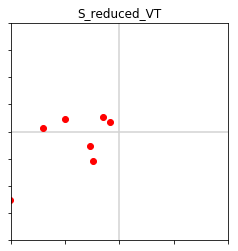

In [113]:
# plot the array
p = plt.subplot(111)
p.axis('scaled'); p.axis([-2, 2, -2, 2]); p.axhline(y=0, color='lightgrey'); p.axvline(x=0, color='lightgrey')
p.set_yticklabels([]); p.set_xticklabels([])

p.set_title("S_reduced_VT")
p.plot(S_reduced_VT[0,],S_reduced_VT[1,],'ro')

plt.show()

In [147]:
# each Singular Value vector is a linear combination of original words
U_S_reduced = numpy.dot(U, S_reduced)
df = pd.DataFrame(numpy.round(U_S_reduced, decimals=2), index=vocab)

# show colour coded so it is easier to see significant word contributions to a topic
df.style.background_gradient(cmap=plt.get_cmap('Blues'), low=0, high=2)
df.sort_values(0)

NameError: name 'S_reduced' is not defined

##### When is the SVD Technique Appropriate?
For most Text Mining problems, the SVD will be entirely appropriate to use. Without a data reduction technique, there will be more variables (terms) available than one can use in a data mining model. Some method must be applied to select an appropriate set from which a text mining solution can be built. Unlike term elimination, the SVD technique allows one to derive significantly fewer variables from the original variables. There are some drawbacks to using the SVD, however. Computationally, the SVD is fairly resource intensive and requires a large amount of RAM. The user must have access to these resources in order for the decomposition to be obtained.

##### How Many Dimensions Should be Used?
The choice for the number of dimensions k to use can be a crucial aspect of many text mining solutions. With too few dimensions, the model will fail to explain prominent relationships in the text. On the other hand, using too many dimensions will add unnecessary noise to the model and make training an effective model nearly impossible. In practice, there is an upper bound of at most a few hundred dimensions from which to build a model. So the user should not need to consider more than this

### SVD in comparision to PCA
Using the below image displaying several documents that contain only two terms (A&B)

**SVD:** draw a line through the points in such a way that the sum of the distances from each point to the line is minimized. The documents can then be perpendicularly projected onto this new line. The circles indicate the locations of the projected documents. This line and the new locations for the documents, can be obtained by using the SVD

**PCA:** Spread the points out as much as possible on this new line to maximize the variance of the points that are projected onto the line. This line is formed by performing Principal Component Analysis

Although based on equivalent procedures, since PCA and TM’s SVD approach operate on different data, they do not produce the same results. Depending on whether the raw data is used or the covariance matrix is used, different vectors will be found as basis vectors for the reduced space

While the PCA component maximizes the variance,
the SVD finds the best fitting line in the least-squares
sense. The SVD line is affected by the dispersement
of Word_B when Word_A occurs between 0 and 10
times while the PCA line is not influenced by this
secondary variation. Depending on the nature of the
data, these two lines may or may not be fairly close
to one another. If Text Miner were to use the meanadjusted
term-document frequency data, rather than
the raw data, the SVD approach and PCA, applied
to the covariance matrix, would produce identical results. This is in part because all columns in a term-document matrix have the same scale.

r does not use the covariance or correlation
matrix, or even form the mean-adjusted matrix
for a very good reason: the resulting matrix would no longer be sparse. The dimensions of A are so large,
that taking advantage of a compressed representation
as given in Table 2 is a requirement. Forming
the mean-adjusted matrix would not allow this.

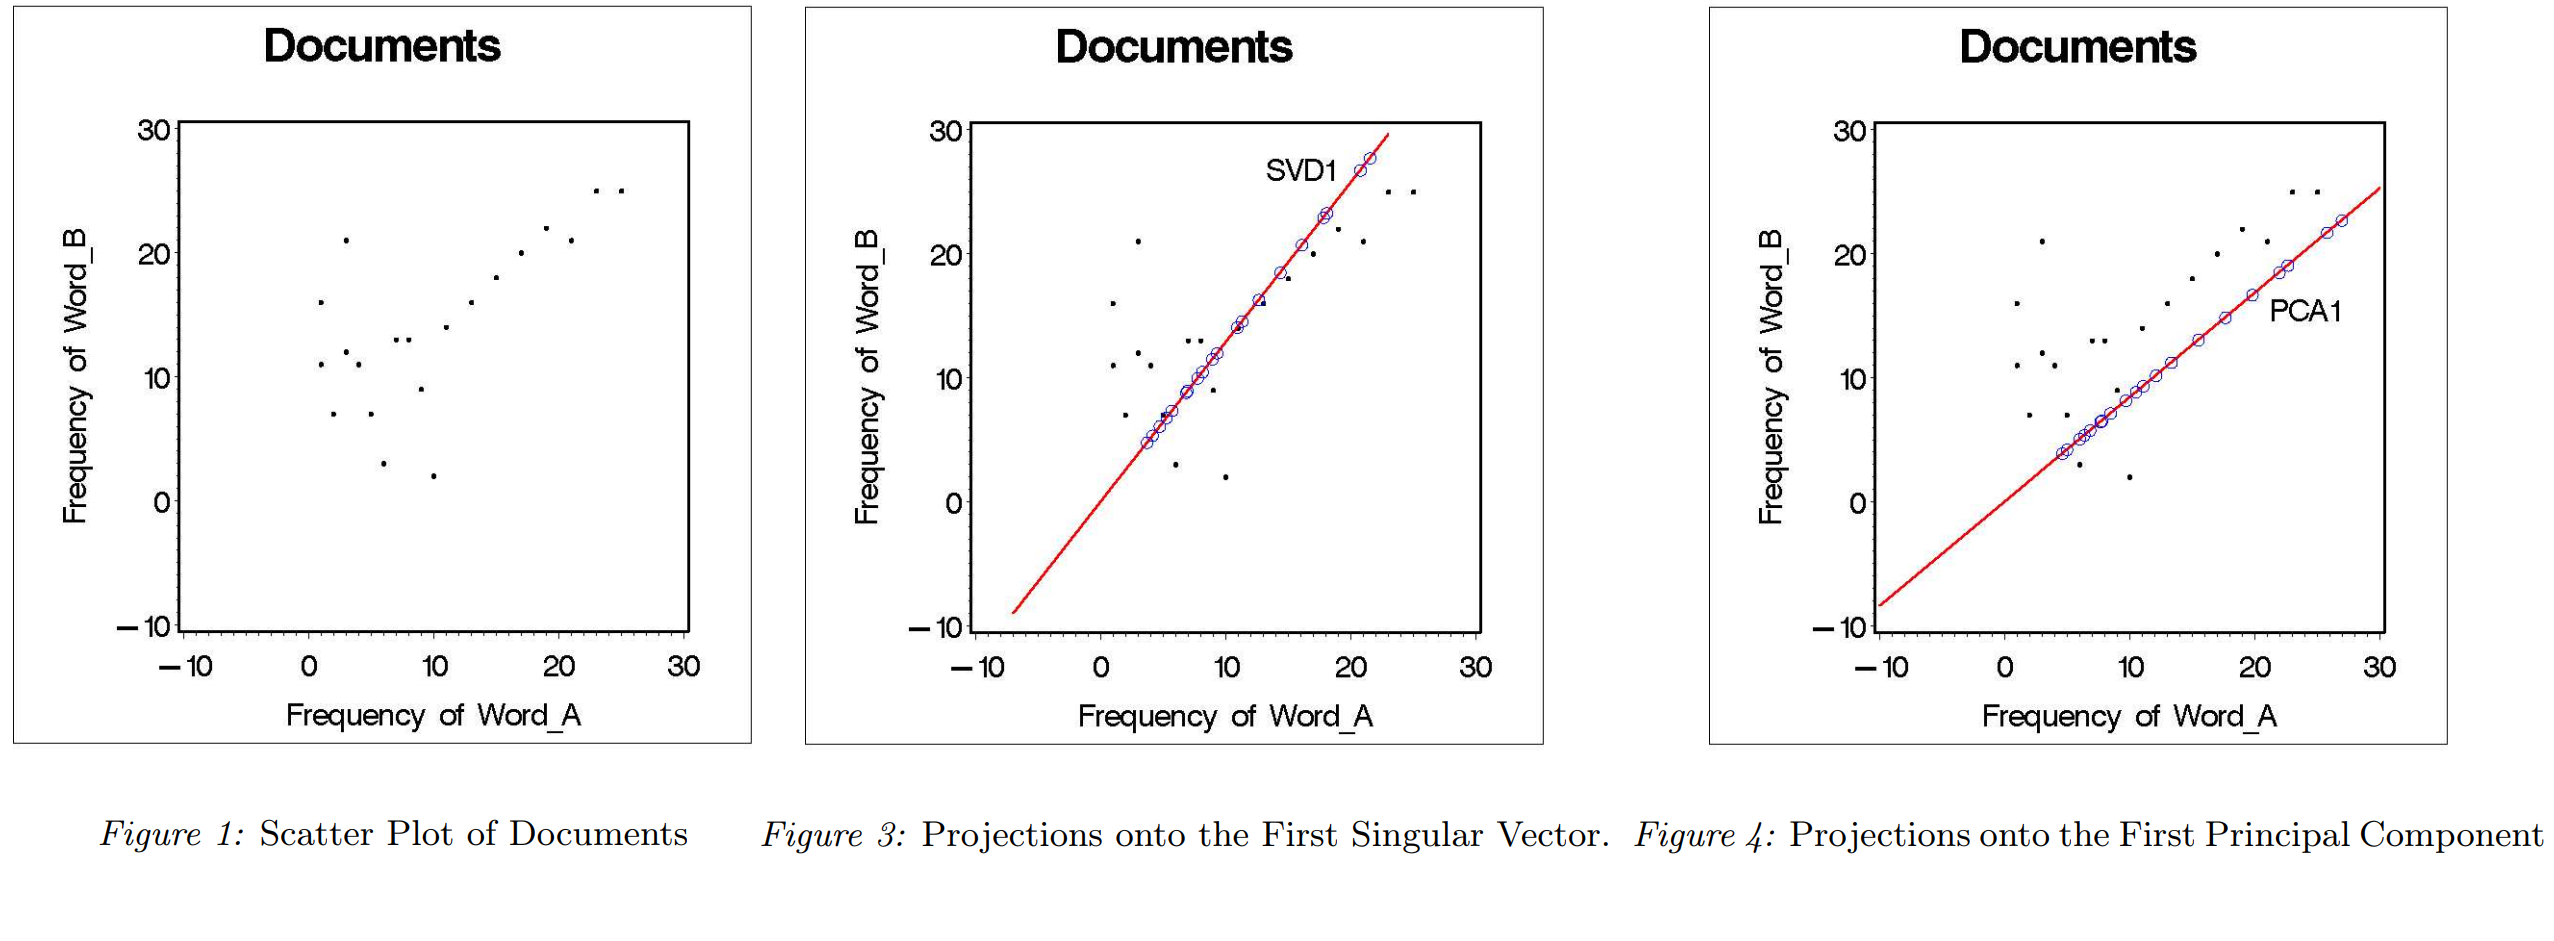

In [140]:
# SVD vs PCA
Image("../../raw_data/images/svd_vs_pca.png", width=1000)

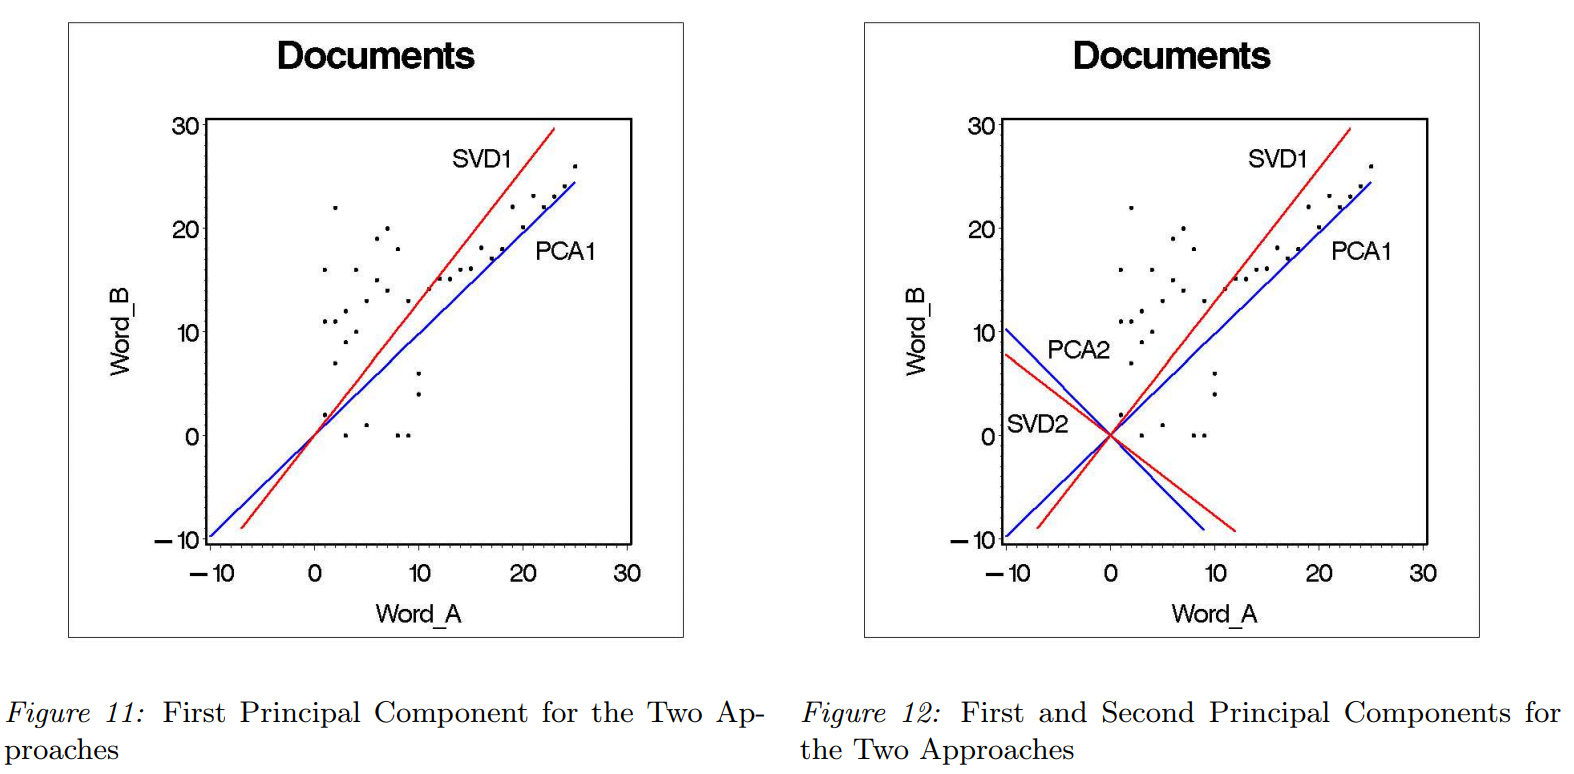

In [139]:
# SVD vs PCA
Image("../../raw_data/images/svd_vs_pca2.png", width=700)

### Latent Semantic Indexing (LSI)
Latent semantic indexing (LSI) is an indexing and retrieval method that uses a mathematical technique called singular value decomposition (SVD) to identify patterns in the relationships between the terms and concepts contained in an unstructured collection of text. LSI is based on the principle that words that are used in the same contexts tend to have similar meanings. A key feature of LSI is its ability to extract the conceptual content of a body of text by establishing associations between those terms that occur in similar contexts.[18]

The method, also called latent semantic analysis (LSA), uncovers the underlying latent semantic structure in the usage of words in a body of text and how it can be used to extract the meaning of the text in response to user queries, commonly referred to as concept searches. Queries, or concept searches, against a set of documents that have undergone LSI will return results that are conceptually similar in meaning to the search criteria even if the results don’t share a specific word or words with the search criteria.

### Overview
LSA can use a term-document matrix which describes the occurrences of terms in documents; it is a sparse matrix whose rows correspond to terms and whose columns correspond to documents. A typical example of the weighting of the elements of the matrix is tf-idf (term frequency–inverse document frequency): the weight of an element of the matrix is proportional to the number of times the terms appear in each document, where rare terms are upweighted to reflect their relative importance.

This matrix is also common to standard semantic models, though it is not necessarily explicitly expressed as a matrix, since the mathematical properties of matrices are not always used.

### Rank Lowering
After the construction of the occurrence matrix, LSA finds a low-rank approximation[4] to the term-document matrix. There could be various reasons for these approximations:

The original term-document matrix is presumed too large for the computing resources; in this case, the approximated low rank matrix is interpreted as an approximation (a "least and necessary evil").
The original term-document matrix is presumed noisy: for example, anecdotal instances of terms are to be eliminated. From this point of view, the approximated matrix is interpreted as a de-noisified matrix (a better matrix than the original).
The original term-document matrix is presumed overly sparse relative to the "true" term-document matrix. That is, the original matrix lists only the words actually in each document, whereas we might be interested in all words related to each document—generally a much larger set due to synonymy.
The consequence of the rank lowering is that some dimensions are combined and depend on more than one term:

{(car), (truck), (flower)} --> {(1.3452 * car + 0.2828 * truck), (flower)}

This mitigates the problem of identifying synonymy, as the rank lowering is expected to merge the dimensions associated with terms that have similar meanings. It also mitigates the problem with polysemy, since components of polysemous words that point in the "right" direction are added to the components of words that share a similar meaning. Conversely, components that point in other directions tend to either simply cancel out, or, at worst, to be smaller than components in the directions corresponding to the intended sense.


### Use Cases
- Compare the documents in the low-dimensional space (data clustering, document classification).
- Find similar documents across languages, after analyzing a base set of translated documents (cross language retrieval).
- Find relations between terms (synonymy and polysemy).
- Given a query of terms, translate it into the low-dimensional space, and find matching documents (information retrieval).
- Find the best similarity between small groups of terms, in a semantic way (i.e. in a context of a knowledge corpus), as for example in multi choice questions MCQ answering model.
- Expand the feature space of machine learning / text mining systems 
- Analyze word association in text corpus 

Synonymy and polysemy are fundamental problems in natural language processing:
* Synonymy is the phenomenon where different words describe the same idea. Thus, a query in a search engine may fail to retrieve a relevant document that does not contain the words which appeared in the query. For example, a search for "doctors" may not return a document containing the word "physicians", even though the words have the same meaning.

* Polysemy is the phenomenon where the same word has multiple meanings. So a search may retrieve irrelevant documents containing the desired words in the wrong meaning. For example, a botanist and a computer scientist looking for the word "tree" probably desire different sets of documents.

### Limitations
LSA cannot capture polysemy (i.e., multiple meanings of a word) because each occurrence of a word is treated as having the same meaning due to the word being represented as a single point in space.[citation needed]. For example, the occurrence of "chair" in a document containing "The Chair of the Board" and in a separate document containing "the chair maker" are considered the same. The behavior results in the vector representation being an average of all the word's different meanings in the corpus, which can make it difficult for comparison. However, the effect is often lessened due to words having a predominant sense throughout a corpus (i.e. not all meanings are equally likely).

SOURCE: https://en.wikipedia.org/wiki/Latent_semantic_analysis#cite_note-38

"The idea behind LSA is that the original corpus consists of a multitude of terms that in essence have the same meaning. The original matrix can in this sense be viewed as an obscured version of the underlying latent structure we discover when the redundant dimensions are forced together."

SOURCE: https://simonpaarlberg.com/post/latent-semantic-analyses/

In [195]:
from gensim.models.ldamodel import LdaModel
from gensim.models import LsiModel

import seaborn as sns
%matplotlib inline

In [196]:
# initialize an LSI transformation
lsi = LsiModel(tfidf_corpus, id2word=dictionary, num_topics=2) 

In [ ]:
lsi.save()

In [192]:
corpus_lsi = lsi[tfidf_corpus] 

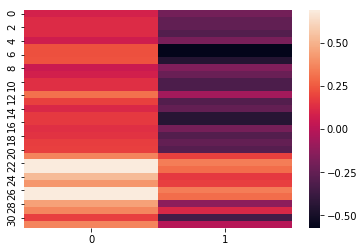

In [190]:
data = []
for row in corpus_lsi:
    row_stats = []
    for topic in row:
        row_stats.append(topic[1])
    data.append(row_stats)

seaborn_df = pd.DataFrame(data)
sns.heatmap(seaborn_df)

In [5]:
seaborn_url = 'https://seaborn.pydata.org/'
iframe = '<iframe src={} width=1000 height=300></iframe>'.format(seaborn_url)
HTML(iframe)

In [130]:
lsi.print_topics(2, num_words=5)

[(0,
  '-0.285*"increase" + -0.283*"percent" + -0.276*"rental" + -0.248*"rental_expense" + -0.236*"expense"'),
 (1,
  '0.304*"passenger" + 0.237*"service" + 0.162*"pay" + -0.161*"percent" + 0.148*"damage"')]

### Recommendation Engine

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

df = pd.DataFrame(texts[0:5], columns=['text'])

vect = TfidfVectorizer(max_features=15)
transform_vect = vect.fit_transform(df['text'])
pd.DataFrame(transform_vect.toarray(), columns=vect.get_feature_names())

from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD()
svd_tranform = svd.fit_transform(transform_vect)
svd_tranform

from sklearn.neighbors import NearestNeighbors
neighbors = NearestNeighbors(metric='cosine')
neighbors.fit(svd_tranform)
neighbors.kneighbors([svd_tranform[0]])
#neighbors.kneighbors_graph(n_neighbors=2, mode='distance').toarray()

### LDA

The normal distribution is a probability distribution over all the real numbers. It is described by a mean and a variance. The mean is the expected value of this distribution, and the variance tells us how much we can expect samples to deviate from the mean. If the variance is very high, then you’re going to see values that are both much smaller than the mean and much larger than the mean. If the variance is small, then the samples will be very close to the mean. If the variance goes close to zero, all samples will be almost exactly at the mean.

The dirichlet distribution is a probability distribution as well - but it is not sampling from the space of real numbers. Instead it is sampling over a probability simplex.

And what is a probability simplex? It’s a bunch of numbers that add up to 1. For example:

(0.6, 0.4)
(0.1, 0.1, 0.8)
(0.05, 0.2, 0.15, 0.1, 0.3, 0.2)

These numbers represent probabilities over K distinct categories. In the above examples, K is 2, 3, and 6 respectively. That’s why they are also called categorical distributions.

When we are dealing with categorical distributions and we have some uncertainty over what that distribution is, simplest way to represent that uncertainty as a probability distribution is the Dirichlet.

SOURCE: https://www.quora.com/What-is-an-intuitive-explanation-of-the-Dirichlet-distribution

VIDEO: https://www.hakkalabs.co/articles/the-dirichlet-distribution

Introduction to Latent Dirichlet Allocation: http://blog.echen.me/2011/08/22/introduction-to-latent-dirichlet-allocation/

In [131]:
ldamodel = LdaModel(
        tfidf_corpus, num_topics=2, id2word=dictionary, passes=200)

ldamodel.print_topics(num_topics=2, num_words=5)

[(0,
  '0.023*"passenger" + 0.020*"service" + 0.018*"southwest" + 0.017*"change" + 0.016*"inspection"'),
 (1,
  '0.019*"rental" + 0.017*"increase" + 0.017*"expense" + 0.016*"landing" + 0.016*"landing_fee"')]

In [132]:
ldamodel.top_topics(corpus)

[([(0.018974580317509881, 'rental'),
   (0.017328061230754692, 'increase'),
   (0.016996578265364378, 'expense'),
   (0.01611641963098397, 'landing'),
   (0.01611641963097742, 'landing_fee'),
   (0.015348498895761549, 'percent'),
   (0.014633059876339836, 'rental_expense'),
   (0.01435251539191755, 'damage'),
   (0.013658045675954951, 'cost'),
   (0.013198770476051174, 'in'),
   (0.013004984725550211, 'airtran'),
   (0.012344643086849148, 'compare'),
   (0.012303525281150068, 'seek'),
   (0.012303525281149821, 'relief'),
   (0.01230352528114676, 'injunctive'),
   (0.01193330686936139, 'on'),
   (0.011436652843529512, 'court'),
   (0.011368825590748468, 'asm'),
   (0.01128345481733793, 'delta'),
   (0.011161364311113274, 'increase_by_million_or_percent')],
  -13.726536223002389),
 ([(0.023297363064785311, 'passenger'),
   (0.02030638240568073, 'service'),
   (0.017851455879786128, 'southwest'),
   (0.017125052016583774, 'change'),
   (0.016391845591608657, 'inspection'),
   (0.016391845

## Visdom

Install it with:

`conda install visdom`

Start the server:

`python -m visdom.server`

Visdom now can be accessed at http://localhost:8097 in the browser.


# LDA Training Visualization

Knowing about the progress and performance of a model, as we train them, could be very helpful in understanding it’s learning process and makes it easier to debug and optimize them. In this notebook, we will learn how to visualize training statistics for LDA topic model in gensim. To monitor the training, a list of Metrics is passed to the LDA function call for plotting their values live as the training progresses. 


<img src="../raw_data/images/visdom_graph.png">


SOURCE: https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/Training_visualizations.ipynb
Visdom SOURCE: https://github.com/facebookresearch/visdom

BLOG POST: https://rare-technologies.com/paruls-gsoc-2017-summary-training-and-topic-visualizations-in-gensim/

In [149]:
from gensim.models.callbacks import CoherenceMetric, DiffMetric, PerplexityMetric, ConvergenceMetric

# define perplexity callback for hold_out and test corpus
#pl_holdout = PerplexityMetric(corpus=holdout_corpus, logger="visdom", title="Perplexity (hold_out)")
#pl_test = PerplexityMetric(corpus=test_corpus, logger="visdom", title="Perplexity (test)")


# u_mass, c_v, c_uci, c_npmi.
# define other remaining metrics available
ch_umass = CoherenceMetric(corpus=tfidf_corpus, coherence="c_v", logger="visdom", title="Coherence (u_mass)", window_size=110)
#ch_cv = CoherenceMetric(corpus=tfidf_corpus, texts=texts, coherence="c_v", logger="visdom", title="Coherence (c_v)")
diff_kl = DiffMetric(distance="kullback_leibler", logger="visdom", title="Diff (kullback_leibler)")
convergence_kl = ConvergenceMetric(distance="jaccard", logger="visdom", title="Convergence (jaccard)")

callbacks = [#pl_holdout, pl_test,  ch_cv,
    diff_kl, convergence_kl, ch_umass]

# training LDA model
ldamodel = LdaModel(
        tfidf_corpus, num_topics=20, id2word=dictionary, passes=200,  callbacks=callbacks)

#model = ldamodel.LdaModel(corpus=training_corpus, id2word=dictionary, num_topics=35, passes=50, chunksize=1500, iterations=200, alpha='auto', callbacks=callbacks)

ValueError: ('%s coherence is not currently supported.', 10)

### Coherence

ABSTRACT: https://people.cs.umass.edu/~wallach/publications/mimno11optimizing.pdf

### Word2Vec

##### There are many things you can do to capture similarity:
- Query expansion with synonym dictionaries
- Separately learning word similarities from large corpora

But a word representation that encodes similarity wins

##### Why do we need Word Embeddings?
"Many machine learning algorithms and almost all Deep Learning Architectures are incapable of processing strings or plain text in their raw form. They require numbers as inputs to perform any sort of job, be it classification, regression etc. in broad terms. And with the huge amount of data that is present in the text format, it is imperative to extract knowledge out of it and build applications."

"So a natural language modelling technique like Word Embedding is used to map words or phrases from a vocabulary to a corresponding vector of real numbers. As well as being amenable to processing by ML algorithms, this vector representation has two important and advantageous properties:

**Dimensionality Reduction** - it is a more efficient representation
**Contextual Similarity** - it is a more expressive representation"

SOURCE: 
- https://www.analyticsvidhya.com/blog/2017/06/word-embeddings-count-word2veec/
- https://www.quora.com/What-is-word-embedding-in-deep-learning
- https://nlp.stanford.edu/manning/talks/Simons-Institute-Manning-2017.pdf

"Count-based methods compute the statistics of how often some word co-occurs with its neighbor words in a large text corpus, and then map these count-statistics down to a small, dense vector for each word. Predictive models directly try to predict a word from its neighbors in terms of learned small, dense embedding vectors (considered parameters of the model)."

Source: https://www.tensorflow.org/tutorials/word2vec

"Word2vec is a particularly computationally-efficient predictive model for learning word embeddings from raw text. It comes in two flavors, the Continuous Bag-of-Words model (CBOW) and the Skip-Gram model (Section 3.1 and 3.2 in Mikolov et al.). Algorithmically, these models are similar, except that CBOW predicts target words (e.g. 'mat') from source context words ('the cat sits on the'), while the skip-gram does the inverse and predicts source context-words from the target words. This inversion might seem like an arbitrary choice, but statistically it has the effect that CBOW smoothes over a lot of the distributional information (by treating an entire context as one observation). For the most part, this turns out to be a useful thing for smaller datasets. However, skip-gram treats each context-target pair as a new observation, and this tends to do better when we have larger datasets. We will focus on the skip-gram model in the rest of this tutorial."

Source: https://www.tensorflow.org/tutorials/word2vec

In [31]:
from gensim.models import word2vec
corpus = [
          'Text of the first document.',
          'Text of the second document made longer.',
          'Number three.',
          'This is number four.',
]
# we need to pass splitted sentences to the model
tokenized_sentences = [sentence.split() for sentence in corpus]
model = word2vec.Word2Vec(tokenized_sentences, min_count=1)

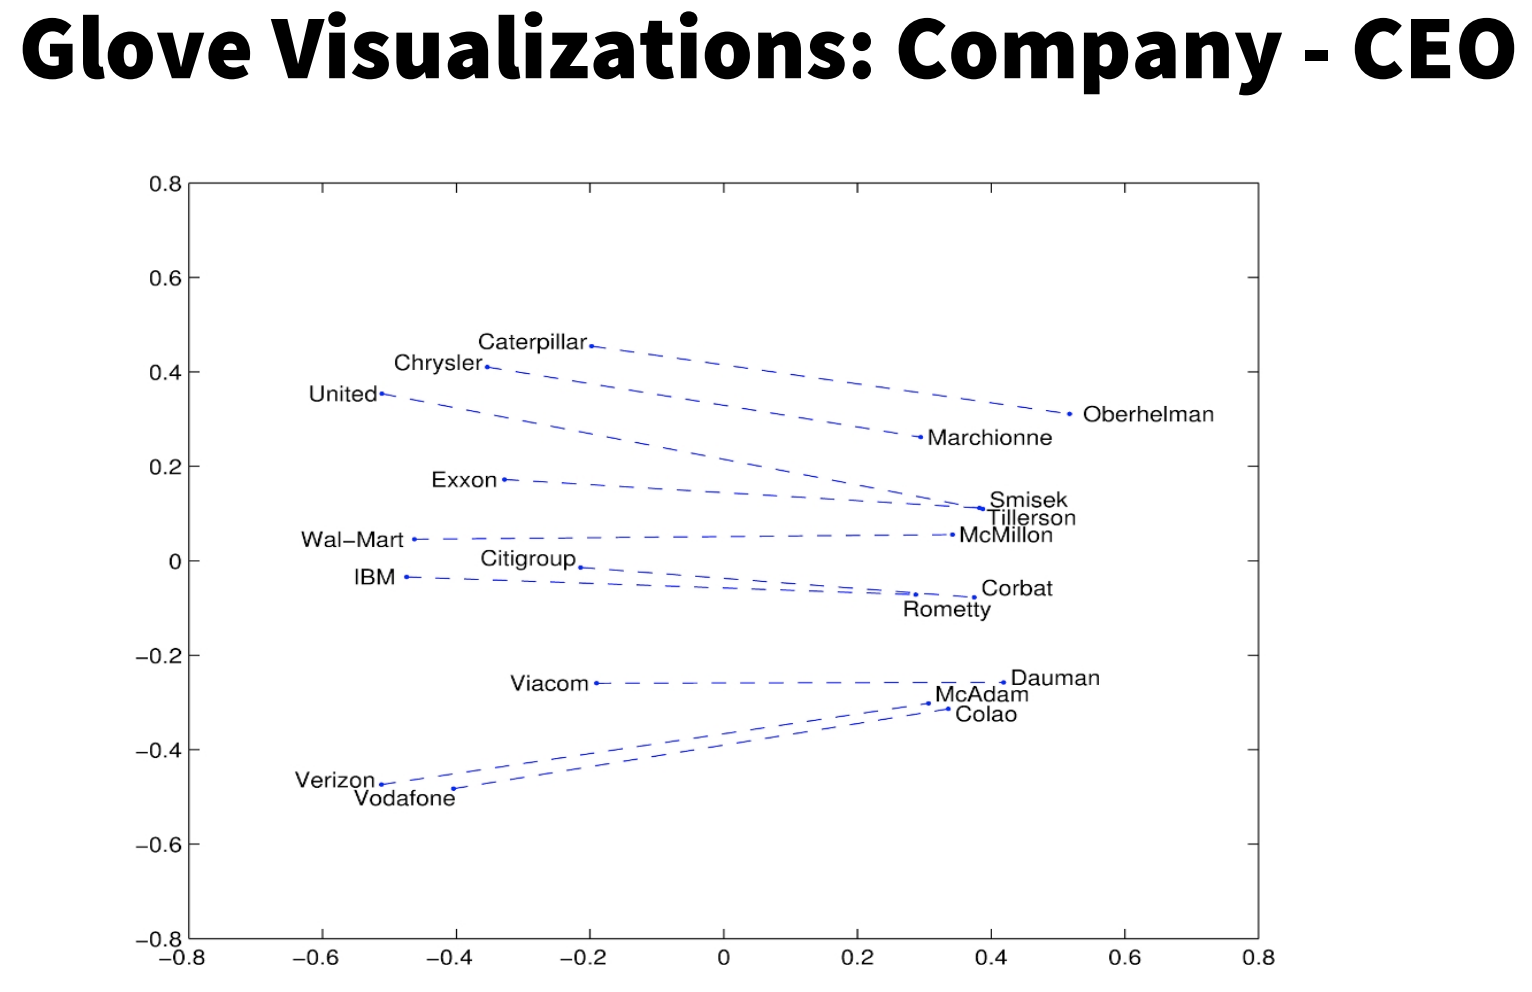

In [32]:
# Document and Word Vectors
Image("../../raw_data/images/glove_visualizations.png", width=400, height=400)

In [ ]:
### T-SNE

In [33]:
cooccur_df.head()

from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
t = tsne.fit_transform(cooccur_df)
df = pd.DataFrame(t)
df.columns=['x','y']
df['group'] = terms
p1=sns.regplot(data=df, x="x", y="y", fit_reg=False, marker="o", color="skyblue", scatter_kws={'s':400})
 
# add annotations one by one with a loop
for line in range(0,df.shape[0]):
     p1.text(df.x[line]+0.2, df.y[line], df.group[line], horizontalalignment='left', size='medium', color='black', weight='semibold')
 
# see it
#sns.plt.show()


NameError: name 'cooccur_df' is not defined

Resources to create content:
- https://towardsdatascience.com/word-embeddings-exploration-explanation-and-exploitation-with-code-in-python-5dac99d5d795
- https://blog.acolyer.org/2016/04/21/the-amazing-power-of-word-vectors/
- https://www.kaggle.com/c/word2vec-nlp-tutorial#what-is-deep-learning
- http://clic.cimec.unitn.it/marco/publications/acl2014/baroni-etal-countpredict-acl2014.pdf
- https://www.analyticsvidhya.com/blog/2017/06/word-embeddings-count-word2veec/